In [48]:
# Step 1: Install & import libraries
!pip install shap xgboost --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score


In [49]:
from google.colab import files
uploaded = files.upload()  # Upload your CSV file here

df = pd.read_csv('/content/claim_data.csv')
df.head()


Saving claim_data.csv to claim_data (2).csv


,Claim ID,Provider ID,Patient ID,Date of Service,Billed Amount,Procedure Code,Diagnosis Code,Allowed Amount,Paid Amount,Insurance Type,Claim Status,Reason Code,Follow-up Required,AR Status,Outcome
0,0HO1FSN4AP,126528997,7936697103,8/7/2024,304,99231,A02.1,218,203,Self-Pay,Paid,Incorrect billing information,Yes,Pending,Partially Paid
1,9U86CI2P5A,6986719948,1547160031,6/21/2024,348,99213,A16.5,216,206,Medicare,Paid,Pre-existing condition,Yes,Open,Denied
2,1QEU1AIDAU,1355108115,2611585318,7/4/2024,235,99213,A00.1,148,119,Commercial,Under Review,Duplicate claim,No,Denied,Denied
3,WH7XDS8CEO,9991055906,7167948632,5/26/2024,112,99215,A18.6,79,69,Medicare,Denied,Authorization not obtained,No,Partially Paid,Denied
4,M6OJEZ8KGI,7382167012,2140226267,7/16/2024,406,99238,A17.9,320,259,Medicare,Denied,Authorization not obtained,No,On Hold,Denied


In [50]:
# STEP 3: Data Cleaning and Alignment

# 1. Convert date column
df['Date of Service'] = pd.to_datetime(df['Date of Service'], errors='coerce')

# 2. Standardize Patient and Provider IDs (string padded to 10 digits)
df[['Patient ID', 'Provider ID']] = (
    df[['Patient ID', 'Provider ID']]
    .astype(str)
    .apply(lambda col: col.str.replace("'", "").str.strip().str.zfill(10))
)

# 3. Strip apostrophes, leading/trailing spaces across object columns
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].str.replace("'", "").str.strip()

# 4. Drop ID/date columns that aren't useful for modeling
df.drop(columns=['Date of Service', 'Claim ID', 'Patient ID', 'Provider ID'], inplace=True, errors='ignore')

# 5. Remove duplicate rows if any
df.drop_duplicates(inplace=True)

# 6. Display missing values (important for imputation decisions)
print("Missing values:\n", df.isnull().sum())

# 7. Convert outcome column to binary target
# Assuming column name is 'Claim Status' with values like 'Denied', 'Approved'
df['Target_Denied'] = df['Claim Status'].apply(lambda x: 1 if x.lower() == 'denied' else 0)
df.drop(columns=['Claim Status'], inplace=True)

# 8. Cap extreme billed amounts at 95th percentile to avoid skew
cap = df['Billed Amount'].quantile(0.95)
df['Billed Amount'] = np.where(df['Billed Amount'] > cap, cap, df['Billed Amount'])

# 9. Save and download
df.to_csv('cleaned_claim_data_final.csv', index=False)

from google.colab import files
files.download('cleaned_claim_data_final.csv')


Missing values:
 Billed Amount         0
Procedure Code        0
Diagnosis Code        0
Allowed Amount        0
Paid Amount           0
Insurance Type        0
Claim Status          0
Reason Code           0
Follow-up Required    0
AR Status             0
Outcome               0
dtype: int64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [51]:
# Use the correct target variable and available columns
df['Denied_Binary'] = df['Outcome'].apply(lambda x: 1 if str(x).strip().lower() == 'denied' else 0)

# View your current columns (just to check what's available)
print(df.columns.tolist())

# Drop only valid non-predictive columns
columns_to_drop = ['Outcome', 'Denied_Binary']  # add others only if they exist
columns_to_drop = [col for col in columns_to_drop if col in df.columns]

X = df.drop(columns=columns_to_drop)
y = df['Denied_Binary']



['Billed Amount', 'Procedure Code', 'Diagnosis Code', 'Allowed Amount', 'Paid Amount', 'Insurance Type', 'Reason Code', 'Follow-up Required', 'AR Status', 'Outcome', 'Target_Denied', 'Denied_Binary']


In [52]:
X = df.drop(columns=['Outcome', 'Target_Denied', 'Denied_Binary'])
y = df['Denied_Binary']
X_encoded = pd.get_dummies(X, drop_first=True)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

In [53]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)


In [54]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import pandas as pd

# Dictionary to store model results
model_results_smote = {}

# Logistic Regression
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)
log_model_smote = LogisticRegression(max_iter=500)
log_model_smote.fit(X_train_resampled, y_train_resampled)
log_preds = log_model_smote.predict(X_test)
model_results_smote['Logistic Regression (SMOTE)'] = {
    'Accuracy': accuracy_score(y_test, log_preds),
    'Report': classification_report(y_test, log_preds, output_dict=True),
    'Confusion Matrix': confusion_matrix(y_test, log_preds)
}

# Random Forest
rf_model_smote = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_smote.fit(X_train_resampled, y_train_resampled)
rf_preds = rf_model_smote.predict(X_test)
model_results_smote['Random Forest (SMOTE)'] = {
    'Accuracy': accuracy_score(y_test, rf_preds),
    'Report': classification_report(y_test, rf_preds, output_dict=True),
    'Confusion Matrix': confusion_matrix(y_test, rf_preds)
}

# XGBoost
xgb_model_smote = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model_smote.fit(X_train_resampled, y_train_resampled)
xgb_preds = xgb_model_smote.predict(X_test)
model_results_smote['XGBoost (SMOTE)'] = {
    'Accuracy': accuracy_score(y_test, xgb_preds),
    'Report': classification_report(y_test, xgb_preds, output_dict=True),
    'Confusion Matrix': confusion_matrix(y_test, xgb_preds)
}

# Summarize results
summary_data_smote = []
for model_name, result in model_results_smote.items():
    accuracy = result['Accuracy']
    precision_1 = result['Report']['1']['precision']
    recall_1 = result['Report']['1']['recall']
    f1_1 = result['Report']['1']['f1-score']
    summary_data_smote.append({
        'Model': model_name,
        'Accuracy': round(accuracy, 3),
        'Precision (Denied)': round(precision_1, 3),
        'Recall (Denied)': round(recall_1, 3),
        'F1 Score (Denied)': round(f1_1, 3)
    })

# Display summary
summary_df_smote = pd.DataFrame(summary_data_smote)
print(summary_df_smote)



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [21:20:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


                         Model  Accuracy  Precision (Denied)  Recall (Denied)  \
0  Logistic Regression (SMOTE)     0.600               0.370            0.303   
1        Random Forest (SMOTE)     0.665               0.481            0.197   
2              XGBoost (SMOTE)     0.630               0.426            0.348   

   F1 Score (Denied)  
0              0.333  
1              0.280  
2              0.383  


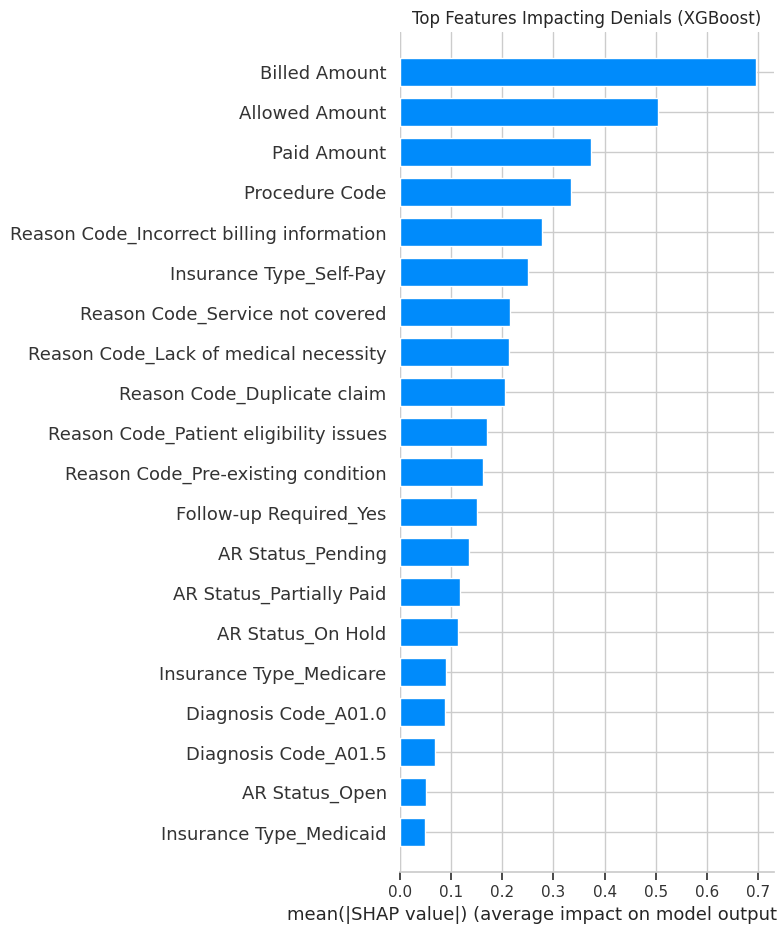

In [55]:
# Initialize SHAP explainer
explainer = shap.TreeExplainer(xgb_model_smote)

# Get SHAP values
shap_values = explainer.shap_values(X_test)

# Summary plot (bar)
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.title("Top Features Impacting Denials (XGBoost)")
plt.tight_layout()
plt.show()



/tmp/ipython-input-3852789934.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=insurance_denials.values, y=insurance_denials.index, palette='viridis')


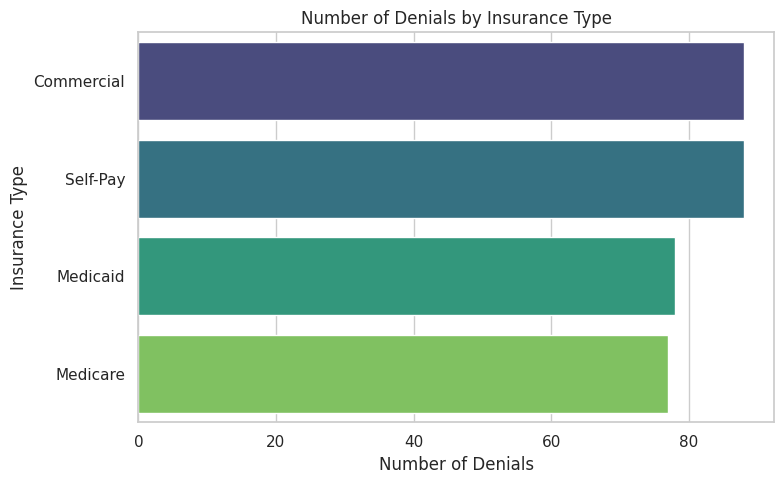

/tmp/ipython-input-3852789934.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Outcome', y='Billed Amount', palette='Set2')


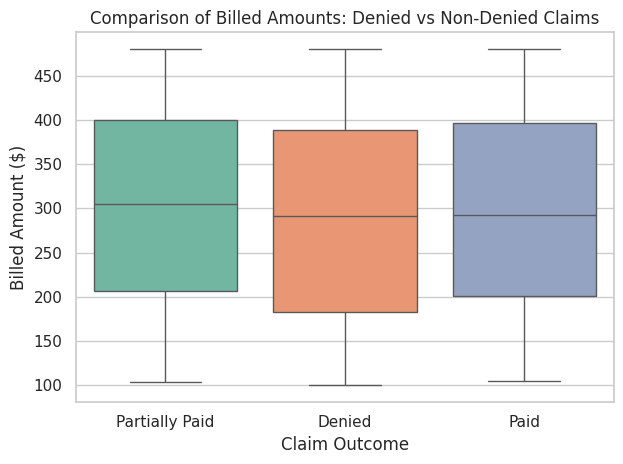

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Bar Plot: Denials by Insurance Type
insurance_denials = df[df['Outcome'] == 'Denied']['Insurance Type'].value_counts()

plt.figure(figsize=(8, 5))
sns.barplot(x=insurance_denials.values, y=insurance_denials.index, palette='viridis')
plt.title('Number of Denials by Insurance Type')
plt.xlabel('Number of Denials')
plt.ylabel('Insurance Type')
plt.tight_layout()
plt.show()

# 2. plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Outcome', y='Billed Amount', palette='Set2')
plt.title('Comparison of Billed Amounts: Denied vs Non-Denied Claims')
plt.xlabel('Claim Outcome')
plt.ylabel('Billed Amount ($)')
plt.tight_layout()


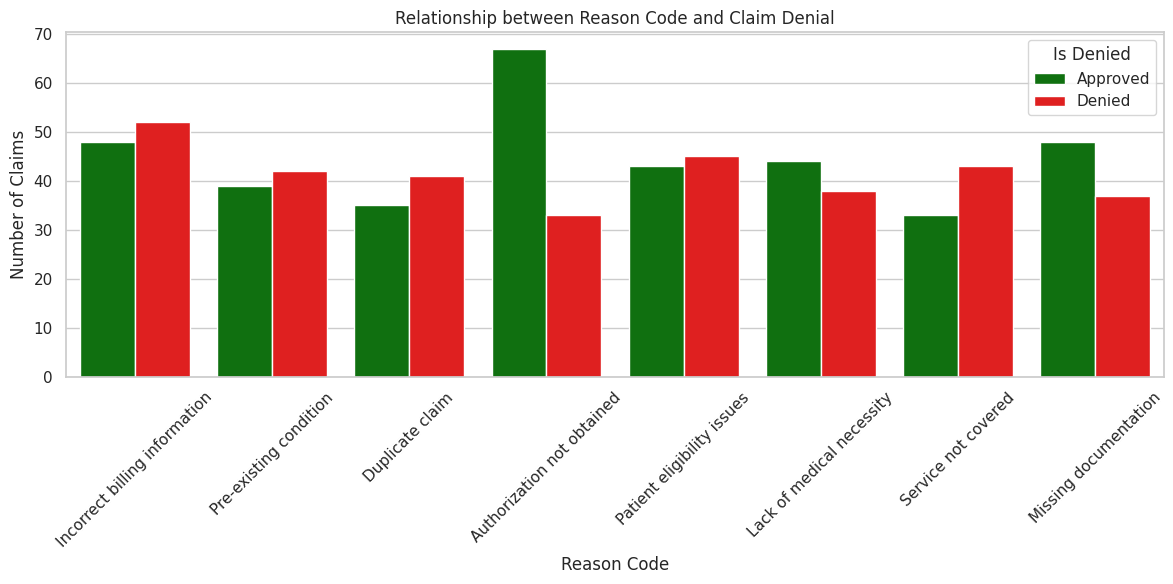

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the cleaned dataset — use raw string or double backslashes
df = pd.read_csv('cleaned_claim_data_final.csv')

# Map Outcome to binary for easier analysis
df['Is_Denied'] = df['Outcome'].map({'Denied': 1, 'Paid': 0})

# Create a countplot to visualize relationship between Reason Code and Denial
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='Reason Code', hue='Is_Denied', palette={0: 'green', 1: 'red'})
plt.title("Relationship between Reason Code and Claim Denial")
plt.xlabel("Reason Code")
plt.ylabel("Number of Claims")
plt.legend(title='Is Denied', labels=['Approved', 'Denied'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



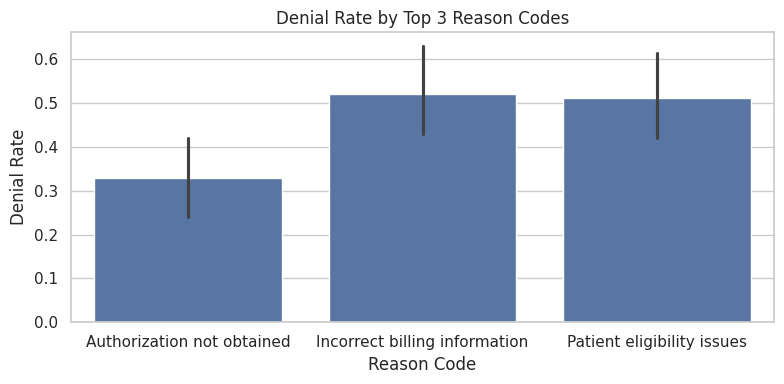

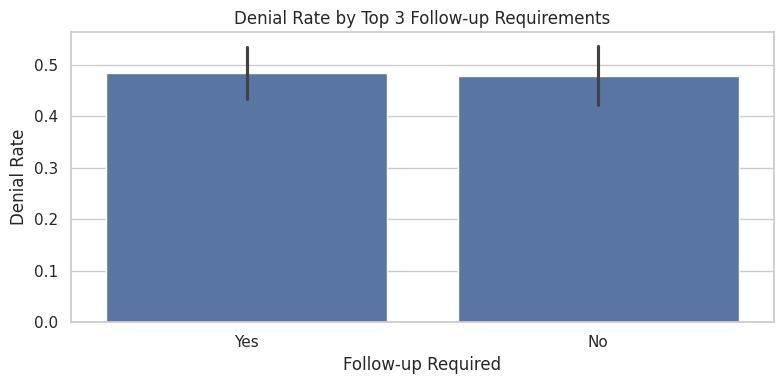

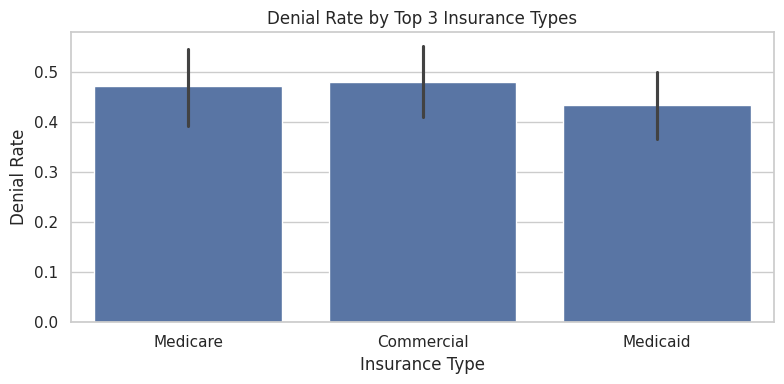

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = "cleaned_claim_data_final.csv"
try:
    df = pd.read_csv(file_path)
except FileNotFoundError:
    raise FileNotFoundError(f"{file_path} not found. Please upload the dataset.")

# Map Outcome to binary for plotting
df['Is_Denied'] = df['Outcome'].map({'Denied': 1, 'Paid': 0})
df = df.dropna(subset=['Is_Denied'])
df['Is_Denied'] = df['Is_Denied'].astype(int)

# Set the plot style
sns.set(style="whitegrid")

# Plot 1: Top 3 Reason Codes
top_reasons = df['Reason Code'].value_counts().nlargest(3).index
plt.figure(figsize=(8, 4))
sns.barplot(data=df[df['Reason Code'].isin(top_reasons)],
            x='Reason Code', y='Is_Denied', estimator='mean')
plt.title("Denial Rate by Top 3 Reason Codes")
plt.ylabel("Denial Rate")
plt.xlabel("Reason Code")
plt.tight_layout()
plt.show()

# Plot 2: Top 3 Follow-up Required values
top_followups = df['Follow-up Required'].value_counts().nlargest(3).index
plt.figure(figsize=(8, 4))
sns.barplot(data=df[df['Follow-up Required'].isin(top_followups)],
            x='Follow-up Required', y='Is_Denied', estimator='mean')
plt.title("Denial Rate by Top 3 Follow-up Requirements")
plt.ylabel("Denial Rate")
plt.xlabel("Follow-up Required")
plt.tight_layout()
plt.show()

# Plot 3: Top 3 Insurance Types
top_insurance = df['Insurance Type'].value_counts().nlargest(3).index
plt.figure(figsize=(8, 4))
sns.barplot(data=df[df['Insurance Type'].isin(top_insurance)],
            x='Insurance Type', y='Is_Denied', estimator='mean')
plt.title("Denial Rate by Top 3 Insurance Types")
plt.ylabel("Denial Rate")
plt.xlabel("Insurance Type")
plt.tight_layout()
plt.show()


